In [3]:
import numpy as np
import matplotlib.pyplot as plt
from random import gauss

#### Plan

Elements: voltage source

Meaningful variables: rotation, position

Noise: rotation of orientation, stretching of shape, etc.

Rest of background must be randomly generated and uniformly distributed, but same density as the image (maybe generate random lines and shapes)

#### Implementation

Each shape stored as a one mask; then just bitwise or each mask together with a zeros array

## Random Number Generation + General Parameters

In [830]:
GRID_SIZE = 1000
CENTER_NOISE_STD_PROPORTION = 0.4
ROT_NOISE_STD = 6
STRETCH_STD = 0.1
MIN_STRETCH, MAX_STRETCH = -0.4, 0.4
ADDITIVE_STD = GRID_SIZE / 500

def get_random_center(lower_padding=0, upper_padding=0, lower_bound=None, upper_bound=None):
    x, y = gauss(0, CENTER_NOISE_STD_PROPORTION*GRID_SIZE), gauss(0, CENTER_NOISE_STD_PROPORTION*GRID_SIZE)
    if lower_bound is None and upper_bound is None:
        lower_bound, upper_bound = -GRID_SIZE//2+1+lower_padding, GRID_SIZE//2-1-lower_padding
    x, y = constrain(x, lower_bound, upper_bound), constrain(y, lower_bound, upper_bound)
    return np.round(np.array([x, y])).astype('int32')
def get_random_rotation(lower_bound=-90, upper_bound =90):
    # Range from -90 to 90
    return constrain(gauss(0, ROT_NOISE_STD), lower_bound, upper_bound)
    return rot
def get_random_stretch(lower_bound=MIN_STRETCH, upper_bound=MAX_STRETCH):
    return 1 + constrain(gauss(0, STRETCH_STD), lower_bound, upper_bound)
def get_additive_noise():
    return int(gauss(0, ADDITIVE_STD))

constrain = lambda val, lower, upper: max(lower, min(upper, val))

## Basic Geometric Shapes

In [1028]:
def rotate(points, theta, noisy=False):
    """
    Inputs:
        points - an nx2 NumPy vector, in which each entry is an (x, y) pair
        theta - degrees by which to rotate
    """
    theta = -theta # CHANGE IF CHANGING IMAGE CONVENTION
    if noisy:
        theta += get_random_rotation()
    theta = np.radians(theta)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    return np.round(rotation_matrix.dot(points.T).T).astype('int32')

def stretch(points, x_factor=None, y_factor=None):
    if x_factor is None and y_factor is None:
        x_factor = get_random_stretch()
        y_factor = get_random_stretch()
    stretch_matrix = np.array([
        [x_factor, 0],
        [0, y_factor]
    ])
    return np.round(stretch_matrix.dot(points.T).T).astype('int32')

def line(length, center, thickness, theta, grid_size, noisy=False):
    """
    Inputs:
        length: overall length of the line, endpoint to endpoint
        theta: counterclockwise angle (degrees) by which the line is rotated
        center: midpoint of the line
        thickness: line is 2*thickness - 1 pixels thick
    """
    center = center.astype('int32')
    if center is None:
        center = get_random_center(length, length)
    grid = np.zeros((grid_size, grid_size))
    points = np.array([[x, y] for x in range(int(-length//2), int(length//2)+1) for y in range(-thickness+1, thickness)])
    points = rotate(points, theta, noisy=noisy)
    if noisy:
        for pt in points:
            grid[pt[1] + center[1] + get_additive_noise()][pt[0] + center[0] + get_additive_noise()] = 1
    else:
        for pt in points:
            grid[pt[1] + center[1]][pt[0] + center[0]] = 1
    return np.roll(grid, (grid_size//2+1, grid_size//2+1), axis=(0, 1))

def line_endpoint(start, end, thickness, grid_size, noisy=False):
    length = int(np.sqrt((start[0] - end[0])**2 + (start[1] - end[1])**2))
    midpoint = (start + end) / 2
    # CHANGE IF CONVENTION CHANGES; negated theta
    theta = -np.degrees(np.arctan((start[1] - end[1]) / (start[0] - end[0])) if start[0] != end[0] else 90)
    return line(length, midpoint, thickness, theta, grid_size, noisy=noisy)

def circle(radius, center, thickness, grid_size, noisy=False):
    if center is None:
        stretch_padding = (GRID_SIZE//2-1)/(1 + MAX_STRETCH)
        center = get_random_center(lower_bound=-stretch_padding+thickness+radius, upper_bound=stretch_padding-thickness-radius)
    plus_epsilon = 2*radius*thickness - thickness**2 # (r+thickness)^2 - r^2
    minus_epsilon = 2*radius*thickness - thickness**2 # r^2 - (r - thickness)^2
    grid_center = np.array([grid_size//2, grid_size//2])
    grid = np.zeros((grid_size, grid_size))
    xx, yy = np.mgrid[-grid_size//2:grid_size//2, -grid_size//2:grid_size//2]
    zero_dists = xx**2 + yy**2
    points = np.argwhere(np.logical_and(zero_dists > radius**2 - minus_epsilon, zero_dists < radius**2 + plus_epsilon))
    points -= (GRID_SIZE//2) * np.ones((len(points), 2)).astype('int32')
    
    if noisy:
        stretched_points = stretch(points)
    else:
        stretched_points = points
    if noisy:
        for pt in stretched_points:
            grid[pt[0] + center[1] + get_additive_noise()][pt[1]+center[0]+get_additive_noise()] = 1
    else:
        for pt in stretched_points:
            grid[pt[0] + center[1]][pt[1]+center[0]] = 1
    return np.roll(grid, (grid_size//2, grid_size//2), axis=(0, 1))

## Composite Geometric Shapes

Plus, arrow, triangle

In [1029]:
def plus_mask(size, center, thickness, theta, grid_size, noisy=False):
    if center is None:
        center = get_random_center(size, size)
    if noisy:
        horizontal = line(size, center + np.array([get_additive_noise(), get_additive_noise()]), thickness, 0, grid_size, noisy=noisy)
        vertical = line(size, center + np.array([get_additive_noise(), get_additive_noise()]), thickness, 90, grid_size, noisy=noisy)
    else:
        horizontal = line(size, center, thickness, 0, grid_size, noisy=noisy)
        vertical = line(size, center, thickness, 90, grid_size, noisy=noisy)        
    return np.logical_or(horizontal, vertical)

def arrow(size, center, thickness, theta, grid_size, noisy=False):
    # Allow for arbitrary centers to add to background data and be more robust against false positives
    # default points downwards
    if center is None:
        center = get_random_center(size, size)
    grid = line(size, center, thickness, 90, grid_size, noisy=noisy)
    OTHER_LINE_RATIO, ENDPOINT_NOISE_RATIO = 0.4, 10
    other_size = OTHER_LINE_RATIO*size
    if noisy:
        left_line = line_endpoint(center+np.array([0, size/2]),
                              center+np.array([-other_size/2+get_additive_noise()*ENDPOINT_NOISE_RATIO,
                                               -other_size*(1-np.sqrt(3)/2) + get_additive_noise()*ENDPOINT_NOISE_RATIO]),
                             thickness, grid_size)
        right_line = line_endpoint(center+np.array([0, size/2]),
                              center+np.array([other_size/2+get_additive_noise()*ENDPOINT_NOISE_RATIO,
                                               -other_size*(1-np.sqrt(3)/2) + get_additive_noise()*ENDPOINT_NOISE_RATIO]),
                              thickness, grid_size)
    else:
        left_line = line_endpoint(center+np.array([0, size/2]),
                              center+np.array([-other_size/2,
                                               -other_size*(1-np.sqrt(3)/2)]),
                             thickness, grid_size)
        right_line = line_endpoint(center+np.array([0, size/2]),
                              center+np.array([other_size/2,
                                               -other_size*(1-np.sqrt(3)/2)]),
                              thickness, grid_size)
    points = np.argwhere(np.logical_or(grid, np.logical_or(left_line, right_line)))
    demean_matrix = np.array([
        [center[1] + grid_size//2, 0],
        [0, center[0] + grid_size//2]
    ])
    points_demeaned = points - np.ones((len(points), 2)).dot(demean_matrix)
    rotated_demeaned = rotate(points_demeaned, theta, noisy=noisy)
    grid = np.zeros((grid_size, grid_size))
    for pt in rotated_demeaned:
        grid[pt[0] + center[1]][pt[1] + center[0]] = 1 # argwhere gives points as y, x; not x, y
    return np.roll(grid, (grid_size//2, grid_size//2), axis=(1, 0))

## Circuit Elements

Voltage sources, current sources, resistors, capacitors

In [1079]:
def voltage_source_mask(size, center, thickness, theta, grid_size, noisy=False):
    SIZE_RATIO, OFFSET_RATIO = constrain(gauss(0.5, 0.1), 0.15, 0.85), constrain(gauss(0.3, 0.05), 0.15, 0.45)
    # defaults to vertical, with + facing down
    if center is None:
        stretch_padding = (GRID_SIZE//2-1)/(1 + MAX_STRETCH)
        center = get_random_center(lower_bound=-stretch_padding+thickness+size, upper_bound=stretch_padding-thickness-size)
    if noisy:
        theta += get_random_rotation()
    grid = circle(size, center, thickness, grid_size, noisy=noisy)
    grid = np.logical_or(grid,
                         plus_mask(size,
                                   center+np.array([get_additive_noise(), get_additive_noise() + int(OFFSET_RATIO*size)]),
                                   thickness, theta, grid_size, noisy=noisy))
    grid = np.logical_or(grid,
                         line(size,
                              center-np.array([get_additive_noise(), get_additive_noise() + int(OFFSET_RATIO*size)]),
                              thickness, 0, grid_size, noisy=noisy))
    points = np.argwhere(grid)
    demean_matrix = np.array([
        [center[1] + grid_size//2, 0],
        [0, center[0] + grid_size//2]
    ])
    points_demeaned = points - np.ones((len(points), 2)).dot(demean_matrix)
    rotated_demeaned = rotate(points_demeaned, theta, noisy=noisy)
    grid = np.zeros((grid_size, grid_size))
    for pt in rotated_demeaned:
        grid[pt[0] + center[1]][pt[1] + center[0]] = 1 # argwhere gives points as y, x; not x, y
    return np.roll(grid, (grid_size//2, grid_size//2), axis=(1, 0))

def current_source_mask(size, center, thickness, theta, grid_size, noisy=False):
    if center is None:
        stretch_padding = (GRID_SIZE//2-1)/(1 + MAX_STRETCH)
        center = get_random_center(lower_bound=-stretch_padding+thickness+size, upper_bound=stretch_padding-thickness-size)
    if noisy:
        theta += get_random_rotation()
    grid = circle(size, center, thickness, grid_size, noisy=noisy)
    SIZE_RATIO, OFFSET_RATIO = constrain(gauss(0.5, 0.1), 0.15, 0.85), constrain(gauss(0.3, 0.05), 0.15, 0.45)
    grid = np.logical_or(grid,
                         plus_mask(size*SIZE_RATIO,
                                   center+np.array([get_additive_noise(), get_additive_noise() + int(OFFSET_RATIO*size)]),
                                   thickness, grid_size, noisy=noisy))
    grid = np.logical_or(grid,
                         line(size*SIZE_RATIO,
                              center-np.array([get_additive_noise(), get_additive_noise() + int(OFFSET_RATIO*size)]),
                              thickness, theta, grid_size, noisy=noisy))
    points = np.argwhere(grid)
    demean_matrix = np.array([
        [center[1] + grid_size//2, 0],
        [0, center[0] + grid_size//2]
    ])
    points_demeaned = points - np.ones((len(points), 2)).dot(demean_matrix)
    rotated_demeaned = rotate(points_demeaned, theta, noisy=noisy)
    grid = np.zeros((grid_size, grid_size))
    for pt in rotated_demeaned:
        grid[pt[0] + center[1]][pt[1] + center[0]] = 1 # argwhere gives points as y, x; not x, y
    return np.roll(grid, (grid_size//2, grid_size//2), axis=(1, 0))

In [ ]:
SIZE_RATIO, OFFSET_RATIO = constrain(gauss(0.5, 0.1), 0.15, 0.85), constrain(gauss(0.3, 0.05), 0.15, 0.45)
def source_mask(size, center, thickness, theta, grid_size, source_func, noisy=False):
    """
    source_func takes the rest of the parameters and returns a grid to overlay onto the source
    """
    print(size)
    print(SIZE_RATIO)
    # defaults to vertical, facing down
    if center is None:
        stretch_padding = (GRID_SIZE//2-1)/(1 + MAX_STRETCH)
        center = get_random_center(lower_bound=-stretch_padding+thickness+size, upper_bound=stretch_padding-thickness-size)
    if noisy:
        theta += get_random_rotation()
    grid = circle(size, center, thickness, grid_size, noisy=noisy)
    grid = np.logical_or(grid,
                         source_func(size*SIZE_RATIO,
                                   center+np.array([get_additive_noise(), get_additive_noise() + int(OFFSET_RATIO*size)]),
                                   thickness, theta, grid_size, noisy=noisy))
    points = np.argwhere(grid)
    demean_matrix = np.array([
        [center[1] + grid_size//2, 0],
        [0, center[0] + grid_size//2]
    ])
    points_demeaned = points - np.ones((len(points), 2)).dot(demean_matrix)
    rotated_demeaned = rotate(points_demeaned, theta, noisy=noisy)
    grid = np.zeros((grid_size, grid_size))
    for pt in rotated_demeaned:
        grid[pt[0] + center[1]][pt[1] + center[0]] = 1 # argwhere gives points as y, x; not x, y
    return np.roll(grid, (grid_size//2, grid_size//2), axis=(1, 0))

def voltage_source_func(size, center, thickness, theta, grid_size, noisy=False):
    print(size)
    if noisy:
        return np.logical_or(plus_mask(size,
                                   center+np.array([get_additive_noise(), get_additive_noise() + int(OFFSET_RATIO*size)]),
                                   thickness, theta, grid_size, noisy=noisy),
                            line(size,
                              center-np.array([get_additive_noise(), get_additive_noise() + int(OFFSET_RATIO*size)]),
                              thickness, theta, grid_size, noisy=noisy))
    else:
        return np.logical_or(plus_mask(size,
                                   center+np.array([0, int(OFFSET_RATIO*size)]),
                                   thickness, theta, grid_size, noisy=noisy),
                            line(size,
                              center-np.array([0, int(OFFSET_RATIO*size)]),
                              thickness, theta, grid_size, noisy=noisy))

def voltage_source_mask(size, center, thickness, theta, grid_size, noisy=False):
    #return source_mask(size, center, thickness, theta, grid_size, voltage_source_func, noisy=noisy)
    # defaults to vertical, with + facing down
    if center is None:
        stretch_padding = (GRID_SIZE//2-1)/(1 + MAX_STRETCH)
        center = get_random_center(lower_bound=-stretch_padding+thickness+size, upper_bound=stretch_padding-thickness-size)
    if noisy:
        theta += get_random_rotation()
    grid = circle(size, center, thickness, grid_size, noisy=noisy)
    grid = np.logical_or(grid,
                         plus_mask(size,
                                   center+np.array([get_additive_noise(), get_additive_noise() + int(OFFSET_RATIO*size)]),
                                   thickness, grid_size, noisy=noisy))
    grid = np.logical_or(grid,
                         line(size,
                              center-np.array([get_additive_noise(), get_additive_noise() + int(OFFSET_RATIO*size)]),
                              thickness, 0, grid_size, noisy=noisy))
    points = np.argwhere(grid)
    demean_matrix = np.array([
        [center[1] + grid_size//2, 0],
        [0, center[0] + grid_size//2]
    ])
    points_demeaned = points - np.ones((len(points), 2)).dot(demean_matrix)
    rotated_demeaned = rotate(points_demeaned, theta, noisy=noisy)
    grid = np.zeros((grid_size, grid_size))
    for pt in rotated_demeaned:
        grid[pt[0] + center[1]][pt[1] + center[0]] = 1 # argwhere gives points as y, x; not x, y
    return np.roll(grid, (grid_size//2, grid_size//2), axis=(1, 0))

def current_source_mask(size, center, thickness, theta, grid_size, noisy=False):
    if center is None:
        stretch_padding = (GRID_SIZE//2-1)/(1 + MAX_STRETCH)
        center = get_random_center(lower_bound=-stretch_padding+thickness+size, upper_bound=stretch_padding-thickness-size)
    if noisy:
        theta += get_random_rotation()
    grid = circle(size, center, thickness, grid_size, noisy=noisy)
    SIZE_RATIO, OFFSET_RATIO = constrain(gauss(0.5, 0.1), 0.15, 0.85), constrain(gauss(0.3, 0.05), 0.15, 0.45)
    grid = np.logical_or(grid,
                         plus_mask(size*SIZE_RATIO,
                                   center+np.array([get_additive_noise(), get_additive_noise() + int(OFFSET_RATIO*size)]),
                                   thickness, grid_size, noisy=noisy))
    grid = np.logical_or(grid,
                         line(size*SIZE_RATIO,
                              center-np.array([get_additive_noise(), get_additive_noise() + int(OFFSET_RATIO*size)]),
                              thickness, theta, grid_size, noisy=noisy))
    points = np.argwhere(grid)
    demean_matrix = np.array([
        [center[1] + grid_size//2, 0],
        [0, center[0] + grid_size//2]
    ])
    points_demeaned = points - np.ones((len(points), 2)).dot(demean_matrix)
    rotated_demeaned = rotate(points_demeaned, theta, noisy=noisy)
    grid = np.zeros((grid_size, grid_size))
    for pt in rotated_demeaned:
        grid[pt[0] + center[1]][pt[1] + center[0]] = 1 # argwhere gives points as y, x; not x, y
    return np.roll(grid, (grid_size//2, grid_size//2), axis=(1, 0))

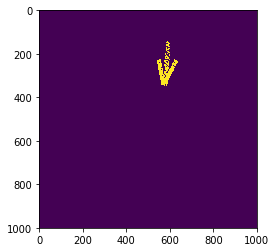

In [1031]:
arr = arrow(GRID_SIZE//5, None, GRID_SIZE//100, 0, GRID_SIZE, True)
plt.imshow(arr)
plt.show()

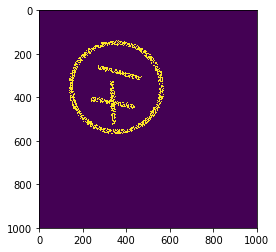

In [1085]:
GRID_SIZE=1000
v = voltage_source_mask(GRID_SIZE//5, None, GRID_SIZE//100, 0, GRID_SIZE, True)
plt.imshow(v)

In [153]:
x = np.array([[1, 2, 3],
             [4, 5, 6],
             [7, 8, 9]])
np.roll(x, (1, 1), axis=(0, 1))

array([[9, 7, 8],
       [3, 1, 2],
       [6, 4, 5]])